### Importing Data and Libraries, and Other Initializations

In [176]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-storm-10/credit_card_default_test.csv
/kaggle/input/data-storm-10/Credit_card_default - Business Problem - Assessment Criteria - Data Dictionary.xlsx
/kaggle/input/data-storm-10/credit_card_default_train.csv
/kaggle/input/data-storm-10/DATA STORM 1.0 - First Round Competition Guidlines.pdf


In [177]:
credit_card_default_train=pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_train.csv')
credit_card_default_test=pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_test.csv')

In [178]:
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [179]:
target_names = ['0','1']

def print_report(X_train, X_val, y_train, y_val, model):
    print('Train Report')
    y_pred_train = model_2.predict(X_train)
    print(classification_report(y_train, y_pred_train, target_names = target_names))

    print('Validation Report')
    y_pred_val = model_2.predict(X_val)
    print(classification_report(y_val, y_pred_val, target_names = target_names))
    
    print('Training f1-score(weighted): %f' % f1_score(y_train, y_pred_train, average = 'weighted'))
    print('Validation f1-score(weighted): %f' % f1_score(y_val, y_pred_val, average = 'weighted'))

#### Load data in and separate feature and labels

In [180]:
_id = 'Client_ID'
target = 'NEXT_MONTH_DEFAULT'

X = credit_card_default_train.drop(target, axis =1)
y = credit_card_default_train.loc[:, target]

# Save Client_IDs of the tests in order to append at the end
test_client_ids =  credit_card_default_test[_id]

X.drop(_id, axis = 1, inplace = True)
credit_card_default_test.drop(_id, axis = 1, inplace = True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_copy= X_train.copy()
X_val_copy = X_val.copy()

### Preprocessing Setup

#### Encoding Setup

In [181]:
def balance_limit_encoder(value):
    """Turns a categorical balance value to a float"""
    last = value[-1]
    value = value[:-1]
    float_val = 0
    
    if last == 'K':
        float_val = float(value) * 1e3
    elif last == 'M':
        float_val = float(value) * 1e6
    return float_val

In [182]:
marital_status_encoder = LabelEncoder()
education_status_encoder = LabelEncoder()
age_encoder = LabelEncoder()

def fit_encoders(fit_data):
    '''Fits the encoders with fit_data'''
    marital_status_encoder.fit(fit_data['MARITAL_STATUS'])
    education_status_encoder.fit(fit_data['EDUCATION_STATUS'])
    age_encoder.fit(fit_data['AGE'])

#### Preprocessing function

In [183]:
unused_cols = ['Balance_Limit_V1', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE']

def preprocess(data):
    '''Encodes categorical columns and removes unused columns and returns the new dataframe'''
    dataset = data.copy()
    
    dataset['Gender'] = pd.Series(
        data['Gender'].map(lambda df : 1 if df == 'M' else 0)
    )
    
    dataset = dataset.assign(
        MARITAL_STATUS_ENC = marital_status_encoder.transform(data['MARITAL_STATUS'])
    )
    
    dataset = dataset.assign(
        EDUCATION_STATUS_ENC = education_status_encoder.transform(data['EDUCATION_STATUS'])
    )
    
    dataset = dataset.assign(AGE_ENC = age_encoder.transform(data['AGE']))
    
    dataset = dataset.assign(
        Balance_Limit_Enc = data['Balance_Limit_V1'].map(balance_limit_encoder)
    )
    
    dataset.drop(unused_cols, axis= 1, inplace = True)
    return dataset

In [184]:
fit_encoders(X_train)

X_train_copy = preprocess(X_train)
X_val_copy = preprocess(X_val)

X_train_copy.head()

,Gender,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,...,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,MARITAL_STATUS_ENC,EDUCATION_STATUS_ENC,AGE_ENC,Balance_Limit_Enc
11152,1,2,0,0,0,0,0,469715,473947,458713,...,18628,21885,11421,12104,12044,23825,1,1,0,500000.0
19068,1,0,0,0,0,0,0,559371,548937,559461,...,18480,18480,16170,13860,13860,16170,1,1,1,1000000.0
14361,0,1,-2,-2,-2,-2,-2,0,0,0,...,0,0,0,0,0,0,1,1,1,200000.0
16141,1,-1,-1,-1,-1,-1,0,54142,0,8894,...,0,8894,0,75514,11550,11550,0,2,0,1000000.0
7033,1,0,0,0,0,0,0,315662,317768,326512,...,12520,15015,11550,12012,11781,11550,1,2,0,400000.0


### Correlation among Features and Target

(Code reused from seaborn documentation)

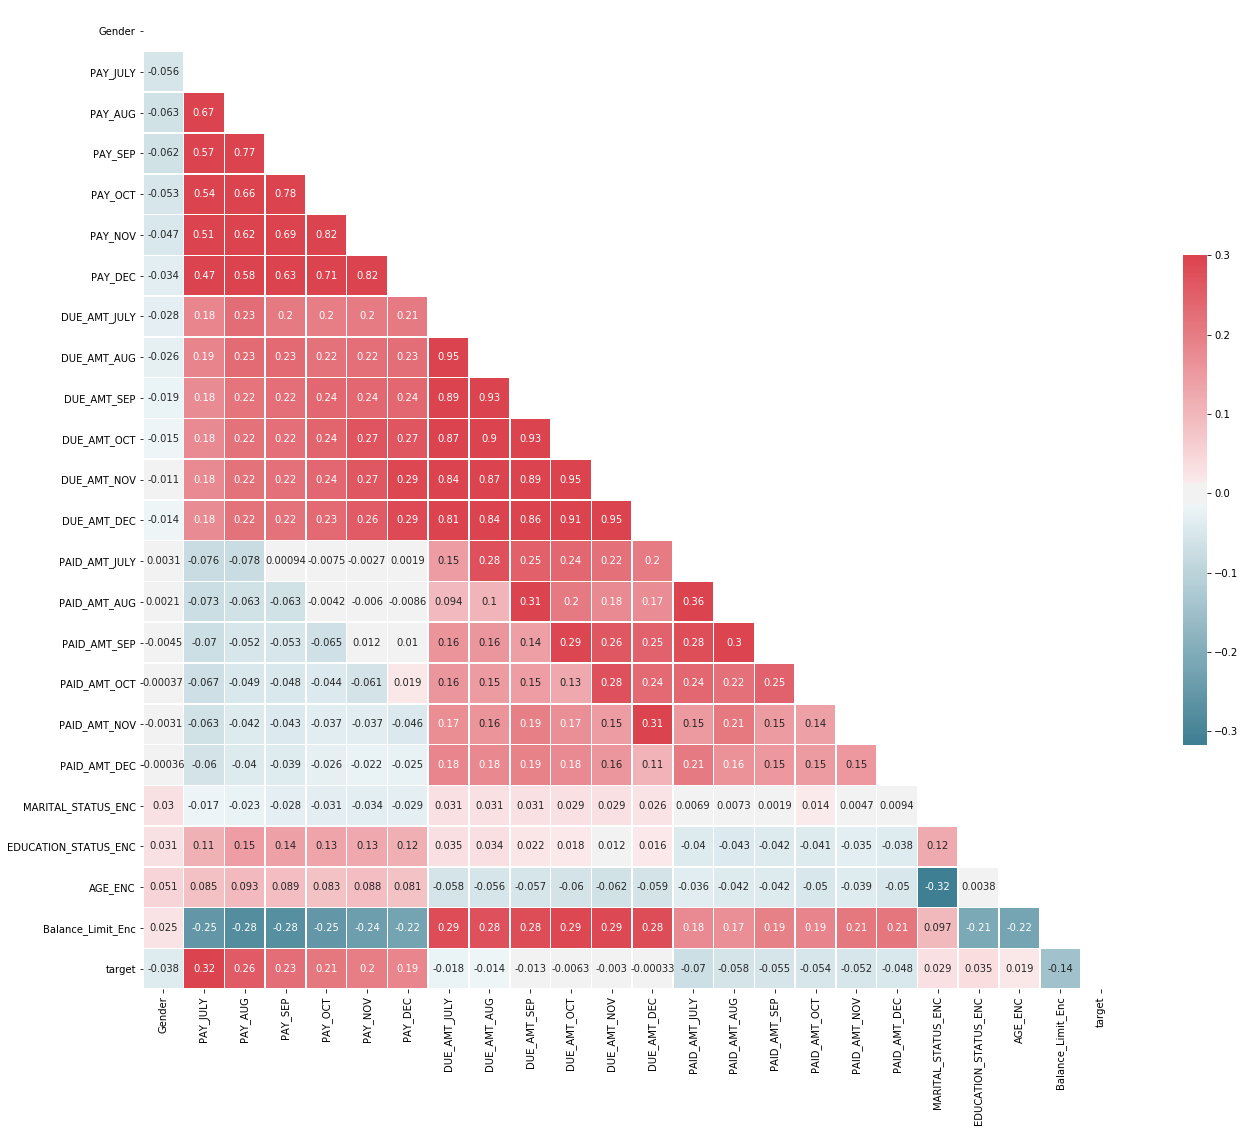

In [185]:
corr = X_train_copy.assign(target = pd.DataFrame(y_train)[target]).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(22,  18))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Classification using a Random Forest Classifier

Train with training data and make predictions on the validation data

In [186]:
n_estimators = 400

X_train = X_train_copy
X_val = X_val_copy

model_1 = RandomForestClassifier(n_estimators = n_estimators)
model_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [187]:
print_report(X_train, X_val, y_train, y_val, model)

Train Report
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     14013
           1       0.70      0.37      0.48      3987

    accuracy                           0.83     18000
   macro avg       0.77      0.66      0.69     18000
weighted avg       0.81      0.83      0.80     18000

Validation Report
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4657
           1       0.71      0.36      0.48      1343

    accuracy                           0.82      6000
   macro avg       0.77      0.66      0.69      6000
weighted avg       0.81      0.82      0.80      6000

Training f1-score(weighted): 0.803457
Validatopm f1-score(weighted): 0.800918


### Classification using Gradient Boosting Classifiers

In [188]:
def f1_eval(y_pred, dtrain):
    '''F1 evaluation metric for boosting classifiers'''
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

#### Using XGBoost

In [189]:
model_2 = XGBClassifier()

model_2.fit(X_train, y_train, eval_metric=f1_eval)

print_report(X_train, X_val, y_train, y_val, model_2)

Train Report
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     14013
           1       0.70      0.37      0.48      3987

    accuracy                           0.83     18000
   macro avg       0.77      0.66      0.69     18000
weighted avg       0.81      0.83      0.80     18000

Validation Report
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4657
           1       0.71      0.36      0.48      1343

    accuracy                           0.82      6000
   macro avg       0.77      0.66      0.69      6000
weighted avg       0.81      0.82      0.80      6000

Training f1-score(weighted): 0.803457
Validatopm f1-score(weighted): 0.800918


#### Using CatBoost

In [190]:
from catboost import CatBoostClassifier, Pool

X_train_cat, X_hold_cat, y_train_cat, y_hold_cat = train_test_split(
    X_train_copy,
    y_train, 
    test_size=0.10, 
    random_state=42
)

eval_set = Pool(X_hold_cat, y_hold_cat)

model_3 = CatBoostClassifier(iterations = 2, learning_rate = 1, depth = 2)
model_3.fit(X_train_cat, y_train_cat, eval_set = eval_set,verbose=False)

print_report(X_train_cat, X_val, y_train_cat, y_val, model_3)

Train Report
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     12599
           1       0.70      0.37      0.48      3601

    accuracy                           0.82     16200
   macro avg       0.77      0.66      0.69     16200
weighted avg       0.81      0.82      0.80     16200

Validation Report
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4657
           1       0.71      0.36      0.48      1343

    accuracy                           0.82      6000
   macro avg       0.77      0.66      0.69      6000
weighted avg       0.81      0.82      0.80      6000

Training f1-score(weighted): 0.803358
Validatopm f1-score(weighted): 0.800918


## Predicting the Targets for the Test Set

We train the final classifier using almost all the data. We take 2% of the data as the evaluation set when fitting the model.

In [197]:
model = XGBClassifier()

X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.02, random_state=42)

fit_encoders(X_train)
X_train = preprocess(X_train)
X_val = preprocess(X_val)

# Preprocess the data to be predicted
X_test = preprocess(credit_card_default_test)

model.fit(X_train, y_train, eval_metric=f1_eval, early_stopping_rounds=5, eval_set=[(X_val, y_val)] )

# Note : Here the validation report is not useful as we have introduced data leakage by using it as 
#        the eval set.

print_report(X_train, X_val, y_train, y_val, model)

Train Report
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     18291
           1       0.70      0.37      0.48      5229

    accuracy                           0.82     23520
   macro avg       0.77      0.66      0.69     23520
weighted avg       0.81      0.82      0.80     23520

Validation Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       379
           1       0.81      0.34      0.48       101

    accuracy                           0.84       480
   macro avg       0.83      0.66      0.69       480
weighted avg       0.84      0.84      0.82       480

Training f1-score(weighted): 0.802528
Validatopm f1-score(weighted): 0.817158


### Predict targets

In [192]:
y_pred = model.predict(X_test)

### Convert the predictions to the required output and generate CSV

In [193]:
df = pd.DataFrame({
    _id : test_client_ids,
    target : y_pred
})

In [194]:
df.head()

,Client_ID,NEXT_MONTH_DEFAULT
0,A20170,0
1,A16887,0
2,A3430,0
3,A3696,0
4,A20474,0


In [195]:
df.to_csv('predictions.csv', index = False)